Recently, I've come across the term Verlet integration several times: an [interesting numerical exploration of a moon explosion by Jason Cole](https://jasmcole.com/2017/09/20/the-moon-blew-up-without-warning-and-for-no-apparent-reason/) and the [wonderful Lennard-Jones molecular dynamics simulator by Daniel Schroeder](http://physics.weber.edu/schroeder/md/). I've been interested in numerical simulation for a long time (and wrote about it [here](http://flothesof.github.io/harmonic-oscillator-three-methods-solution.html) regarding the harmonic oscillator as well as [here](http://flothesof.github.io/charged-particle-trajectories-E-and-B-fields.html) regarding the movement of charged particles in E and B fields) so I think it's time to explore what exactly this numerical ODE integration technique is.

# Verlet integration 

According to [Wikipedia](https://en.wikipedia.org/wiki/Verlet_integration), Verlet integration is named after [Loup Verlet](https://en.wikipedia.org/wiki/Loup_Verlet), a French physicist who published [a paper in 1967 about a model of the Argon gas using 864 particles](https://journals.aps.org/pr/abstract/10.1103/PhysRev.159.98) following forces obeying the Lennard-Jones potential. The integration method that he used in the original paper is written as follows:

$$
\vec{r}_i (t+h) = -\vec{r}_i(t-h)  + 2 \vec{r}_i (t) + \sum_{j \neq i} \vec{f}(r_{ij}(t)) h^2
$$

As stated in the Wikipedia article, the interesting thing about this integration scheme is that it is an order more accurate than integration by simple Taylor expansion alone.

Let's see how we can get this to work on a couple of examples.

# Applications

## Harmonic oscillator

Let's start with the harmonic oscillator.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
class HarmonicOdeVerletSolver:
    def __init__(self, dt, x0, xd0, omega_squared):
        "Inits the solver."
        self.dt = dt
        self.dt_squared = dt**2
        self.t = dt
        self.omega_squared = omega_squared
        self.x0 = x0
        self.xd0 = xd0
        self.x = [-omega_squared * dt**2 + xd0 * dt + x0, x0]
        
    def step(self):
        "Steps the solver."
        xt, xtm1 = self.x
        xtp1 = (2 - self.omega_squared * self.dt_squared) * xt - xtm1
        self.x = (xtp1, xt)
        self.t += self.dt
        
    def step_until(self, tmax, snapshot_dt):
        "Steps the solver until a given time, returns snapshots."
        ts = [self.t]
        vals = [self.x[0]]
        niter = max(1, int(snapshot_dt // self.dt))
        while self.t < tmax:
            for _ in range(niter):
                self.step()
            vals.append(self.x[0])
            ts.append(self.t)
        return np.array(ts), np.array(vals)

In [22]:
solver = HarmonicOdeVerletSolver(0.01, 2, -0.01, 1)

In [23]:
snapshot_dt = .1
ts, vals = solver.step_until(12, snapshot_dt)

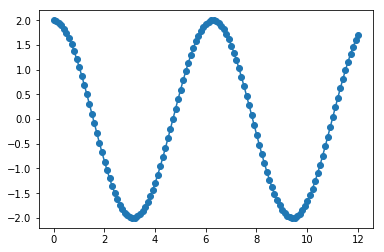

In [24]:
plt.plot(ts, vals, '-o')

Let's see how "stable" this is if we vary the integration step size.

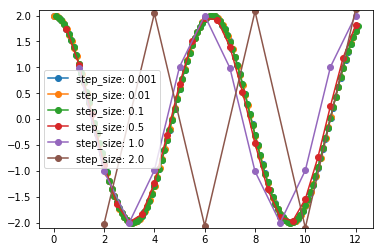

In [26]:
for step_size in [0.001, 0.01, 0.1, 0.5, 1., 2.]:
    solver = HarmonicOdeVerletSolver(step_size, 2, -0.01, 1)
    ts, vals = solver.step_until(12, snapshot_dt)
    plt.plot(ts, vals, "-o", label='step_size: {}'.format(step_size))
plt.legend()
plt.ylim(-2.1, 2.1);

## A two-dimensional spring 

Let's move on to a two-dimensional spring. The difference with the previous example is that the spring is described by a vector instead of a scalar: its position depends on two coordinates. This integrates easily with the vector Verlet update equation that was explained in the theory section.

This time, we thus use a 2d NumPy array to store positions and velocities `x0`, `xd0`.

In [44]:
class TwoDeeSpringVerletSolver:
    def __init__(self, dt, x0, xd0, force_func):
        """Inits the solver. x0 is initial position, 
        force_func is spring force function."""
        self.dt = dt
        self.t = dt
        self.x0 = x0
        self.xd0 = xd0
        self.force_func = force_func
        self.x = [force_func(x0) * dt**2 + xd0 * dt + x0, x0]
        
    def step(self):
        "Steps the solver."
        xt, xtm1 = self.x
        xtp1 = 2 * xt - xtm1 + self.force_func(xt) * self.dt**2
        self.x = (xtp1, xt)
        self.t += self.dt
        
    def step_until(self, tmax, snapshot_dt):
        "Steps the solver until a given time, returns snapshots."
        ts = [self.t]
        vals = [self.x[0]]
        niter = max(1, int(snapshot_dt // self.dt))
        while self.t < tmax:
            for _ in range(niter):
                self.step()
            vals.append(self.x[0])
            ts.append(self.t)
        return np.array(ts), np.array(vals)

In [197]:
force_func = lambda x: -10*(np.linalg.norm(x)) * x / np.linalg.norm(x)
x0 = np.array([0, -1], dtype=np.float)
xd0 = np.array([0.0, 0.1], dtype=np.float)

In [198]:
spring = TwoDeeSpringVerletSolver(0.1, x0, xd0, force_func)

In [199]:
ts, vals = spring.step_until(12, snapshot_dt=0.1)

(-0.055000000000000007,
 0.055000000000000007,
 -1.1200697652032787,
 1.1197691676023391)

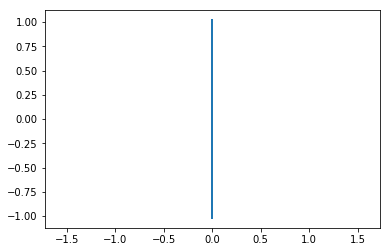

In [200]:
plt.plot(vals[:, 0], vals[:, 1])
plt.axis('equal')

Let's plot the trajectory according to time:

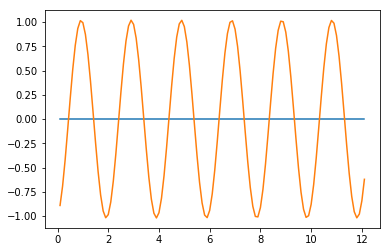

In [201]:
plt.plot(ts, vals[:, 0])
plt.plot(ts, vals[:, 1])

Or as an animation:

In [202]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [203]:
duration = 4

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    index = np.argmin((np.linspace(0, duration, num=ts.size) - t)**2)
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-5:index+1, 0], vals[index-5:index+1, 1], '-')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=30, loop=True, autoplay=True)

 99%|███████████████████████████████████████▋| 120/121 [00:07<00:00, 16.15it/s]


If we give the spring a slight nudge to the right, we get nice oscillations:

In [228]:
xd0 = np.array([-0.5, .1], dtype=np.float)

In [229]:
spring = TwoDeeSpringVerletSolver(0.1, x0, xd0, force_func)

In [230]:
ts, vals = spring.step_until(12, snapshot_dt=0.1)

(-0.17611653437547234,
 0.17613722188491915,
 -1.1200697652032794,
 1.1197691676023394)

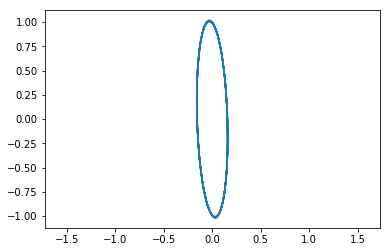

In [231]:
plt.plot(vals[:, 0], vals[:, 1])
plt.axis('equal')

Let's plot the trajectory according to time:

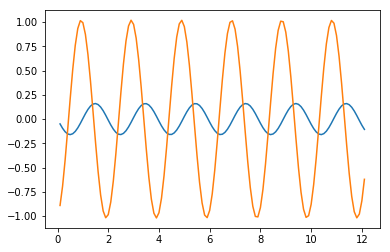

In [232]:
plt.plot(ts, vals[:, 0])
plt.plot(ts, vals[:, 1])

In [233]:
duration = 4

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    index = np.argmin((np.linspace(0, duration, num=ts.size) - t)**2)
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-5:index+1, 0], vals[index-5:index+1, 1], '-')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=30, loop=True, autoplay=True)

 99%|███████████████████████████████████████▋| 120/121 [00:07<00:00, 15.68it/s]


## A pendulum 

The pendulum differs from the spring by the addition of a force component along the negative y axis.

In [253]:
force_func_pendulum = lambda x: -10*(np.linalg.norm(x) - 1) * x / np.linalg.norm(x) + 10*np.array([0, -1])
x0 = np.array([1, 0], dtype=np.float)
xd0 = np.array([0.0, 0.0], dtype=np.float)

In [277]:
pendulum = TwoDeeSpringVerletSolver(0.01, x0, xd0, force_func_pendulum)

ts, vals = pendulum.step_until(14, snapshot_dt=0.05)

(-1.1462860016849188,
 1.2643904397288546,
 -3.7688011372713421,
 0.17841910177482584)

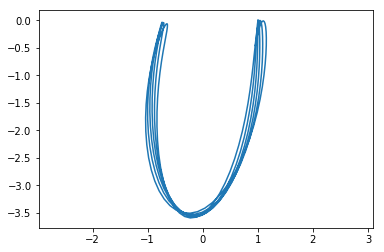

In [278]:
plt.plot(vals[:, 0], vals[:, 1])
plt.axis('equal')

Let's plot the trajectory according to time:

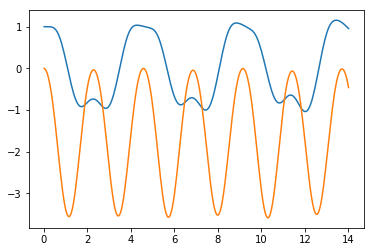

In [279]:
plt.plot(ts, vals[:, 0])
plt.plot(ts, vals[:, 1])

Or as an animation:

In [280]:
duration = 4

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    index = np.argmin((np.linspace(0, duration, num=ts.size) - t)**2)
    ax.plot(vals[index, 0], vals[index, 1], 'o')
    ax.plot(vals[index-5:index+1, 0], vals[index-5:index+1, 1], '-')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-4, 1)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=30, loop=True, autoplay=True)

 99%|███████████████████████████████████████▋| 120/121 [00:06<00:00, 20.35it/s]


## A chain of springs 

## Shooting a cannonball 

## Asteroids around the earth 

## Lennard Jones particles 

## Electromagnetic particles